## 1. Introduction

### Stock price influencers

Features that can be used for stock price predictions

Correlated assets:
an organization interacts with many external factods, including its competitors, clients, the global economy, the geopollitical situation, fiscal and monetary policies, access to capital and so on. Hence its stock price my be correlated nowith other assets suh as commodities, FX, borad based indices and fixed income scorities.

Technical indicators:
A lot of investors follow technical indicators. Moving average, exponential moving average and momentum.

Fundamental analysis:
Annual and querterly reports o fcompanices can be used to extract or determine key metrics such as Return on equity (ROE) and Price to Earnings (P/E)

News can indicate upcoming events that can potentially move the stock price in a certain direction

### Problem definition



## Loading data

- Current data is loaded from yahoo finance and selects the Amundi MSCI World ETF from June 2009 to today.
- The baseline features include:
    - Open
    - High
    - Low
    - Close
    - Volume

In [30]:
import yfinance as yf
import pytz
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd

In [2]:
def dataset_loader(stock_name):
    dataset = yf.download(stock_name)

    start_date = str(dataset.index[0]).split()[0]
    end_date = str(dataset.index[1]).split()[0]

    # close = dataset["Close"]
    return dataset
    

In [3]:
df = dataset_loader('CW8.PA')

[*********************100%***********************]  1 of 1 completed


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3466 entries, 2009-06-16 to 2022-12-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3466 non-null   float64
 1   High       3466 non-null   float64
 2   Low        3466 non-null   float64
 3   Close      3466 non-null   float64
 4   Adj Close  3466 non-null   float64
 5   Volume     3466 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 189.5 KB


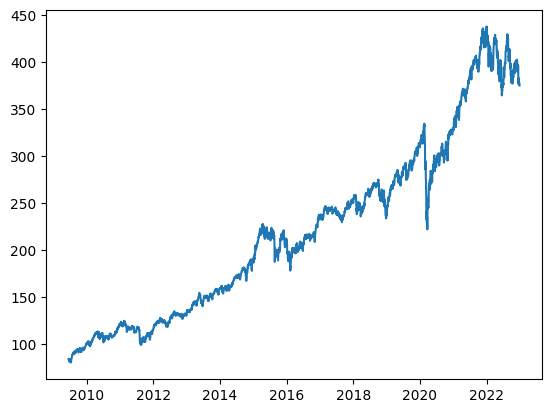

In [5]:
plt.plot(df["Close"])

## Cleaning Data

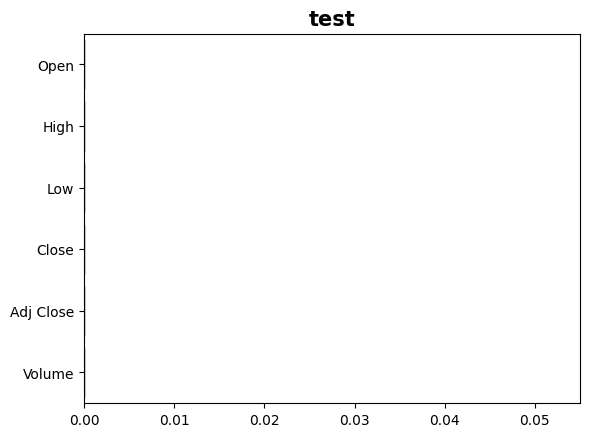

In [6]:
NaN_values = (df.isnull().sum()/len(df)*100).sort_values(ascending=False)

cmap = sns.color_palette("plasma")
fig, ax = plt.subplots()
sns.barplot(x = NaN_values, y=NaN_values.index, edgecolor="black", palette=cmap, ax=ax)

plt.title("test", size = 15, fontweight = "bold")
ax.set_xlim(0,None)
plt.show()


In [7]:
df[df.isna().any(axis=1)]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,


## Data Exploration

In [8]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3466.000000,3466.000000,3466.000000,3466.000000,3466.000000,3466.000000
mean,221.662994,222.226562,221.042052,221.657911,221.657911,2329.262550
std,95.572016,96.276329,94.805598,95.561289,95.561289,7174.689983
min,80.330002,80.330002,80.330002,80.330002,80.330002,0.000000
25%,131.674999,131.674999,131.674999,131.674999,131.674999,0.000000
50%,214.377701,214.377701,214.377701,214.377701,214.377701,0.000000
75%,279.929527,281.369324,278.616547,279.997971,279.997971,2044.000000
max,439.119995,440.440002,436.500000,437.956604,437.956604,95151.000000


## Generating target variable

To define the target variable, we will use the golden cross:
>A golden cross is a chart pattern in which a relatively short-term moving average crosses above a long-term moving average. The golden cross is a bullish breakout pattern formed from a crossover involving a security's short-term moving average (such as the 15-day moving average) breaking above its long-term moving average (such as the 50-day moving average) or resistance level. As long-term indicators carry more weight, the golden cross indicates a bull market on the horizon and is reinforced by high trading volumes.

[Golden Cross reference](https://www.investopedia.com/terms/g/goldencross.asp)

- According to the golden cross rule, the signal (target) will be defined from moving averages windows
- If the short term window > long term window, then the signal becomes 1

In [12]:
def create_target(df, sma1, sma2, tr_id=False):
    # Short moving average
    df['SMA'+str(sma1)] = df['Close'].rolling(sma1).mean() 

    # Long moving average
    df['SMA'+str(sma2)] = df['Close'].rolling(sma2).mean()

    # Generate the target
    df['signal'] = np.where(df['SMA'+str(sma1)] > df['SMA'+str(sma2)], 1, 0)
    display(df['signal'].value_counts())


create_target(df, 15, 50)

1    2392
0    1074
Name: signal, dtype: int64

## Time series visualization

In [15]:

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=df.index, y=df["SMA15"],mode='lines',name="SMA15",line=dict(width=2.0)))
fig.add_trace(go.Scatter(x=df.index, y=df["SMA50"],mode='lines',name="SMA50",line=dict(width=2.0)))
fig.add_trace(go.Scatter(x=df.index, y=df["signal"],mode='lines',name="signal",line=dict(width=2.0)),secondary_y="signal")


fig.update_layout(height=500,width=700,template='plotly_white',title="test", margin=dict(l=50,r=80,t=50,b=40))
fig.show()

## Linear correlations

Text(0.5, 1.0, 'Feature Correlation to signal')

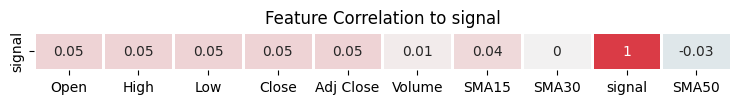

In [29]:
corr_mat = df.corr().round(2).transpose()
shape = corr_mat.shape[0]
corr = corr_mat.loc[:, df.columns == "signal"].transpose()

f, ax = plt.subplots(figsize=(9,0.5))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, vmin=-0.3, vmax=0.3, center=0, cmap=cmap, square=False, lw=2, annot=True, cbar=False)
plt.title(f'Feature Correlation to signal')

The correlation between baseline variables and the target are minimal

This suggests:
- high nonlinearity
- stable osciliations relative to stationnary values
- Feature cannot model the target

## Freature engineering

Adding new technical indicators

- [exponential moving average]("https://www.investopedia.com/terms/e/ema.asp")
- [Price momentum oscilliator]("https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/momentum-oscillator#:~:text=The%20Momentum%20Oscillator%20measures%20the,indicator%20that%20oscillates%20around%20100.")
- [Rate of Change]("https://www.investopedia.com/terms/r/rateofchange.asp")

- [Relative Strenght index]("https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/RSI#:~:text=Description,and%20oversold%20when%20below%2030.")

> The Relative Strength Index (RSI) is a momentum indicator that describes the current price relative to average high and low prices over a previous trading period. This indicator estimates overbought or oversold status and helps spot trend reversals, price pullbacks, and the emergence of bullish or bearish markets.



In [42]:
# Calculate the moving averages
def ma(df, n):
    return pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n)) 

# Calculate exponential moving average
# Places greater signigicance on the most recent data points
def ema(df, n):
    return pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA' + str(n))

# Calculation of price momentum
def mom(df, n):
    return pd.Series(df.diff(n), name='Momentum' + str(n))

# Rate of change
def roc(df, n):
    M = df.diff(n-1)
    N = df.shift(n-1)
    return pd.Series((M/N)*100, name='ROC_'+ str(n))

# Relative Strenght index
def rsi(df, periods, ema=True) -> pd.Series:
    """ Returns a pd.Series with the relative strenght index"""

    # Create two series, one for the lower closes and one for the high closes
    df_delta = df['Close'].diff()
    down = -1 * df_delta.clip(upper=0) # Change the negative values to positive sign
    up = df_delta.clip(lower=0)

    # Use exponential moving average 
    ma_up = up.ewm(com=periods-1, adjust=True, min_periods=periods).mean()
    ma_down = down.ewm(com=periods-1, adjust=True, min_periods=periods).mean()
    rs = ma_up/ma_down
    rsi = 100 - (100/(1+rs))

    return rsi